In [1]:
!pip install pandas pyarrow yfinance fortitudo_tech matplotlib

In [21]:
import numpy as np
import pandas as pd
import yfinance as yf
import fortitudo.tech as ft
from cvxopt import matrix

# Load your dataset
print("Loading portfolio data...")
data = pd.read_parquet("merged_portfolio_data.parquet")

# Set date as index
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

print(f"Original: {data.shape[1]} assets, {data.shape[0]} days")
print(f"Date range: {data.index[0]} to {data.index[-1]}")

# Handle NAs: Drop columns with ANY missing values
data_clean = data.dropna(axis=1, how='any')
print(f"After dropping NA columns: {data_clean.shape[1]} assets")

# Download VIX
print("\nDownloading VIX...")
start_date = data_clean.index[0].strftime('%Y-%m-%d')
end_date = data_clean.index[-1].strftime('%Y-%m-%d')

vix_raw = yf.download('^VIX', start=start_date, end=end_date, progress=False)

# Handle different yfinance return formats
if isinstance(vix_raw.columns, pd.MultiIndex):
    vix_raw = vix_raw['Close']['^VIX']
else:
    vix_raw = vix_raw['Close']

print(f"VIX downloaded: {len(vix_raw)} observations")

# Align VIX with your data dates
vix_aligned = vix_raw.reindex(data_clean.index).ffill()
vix_aligned = vix_aligned.dropna()

# Keep only dates where BOTH data and VIX exist
common_dates = data_clean.index.intersection(vix_aligned.index)
asset_data = data_clean.loc[common_dates]
vix_aligned = vix_aligned.loc[common_dates]

print(f"\nFinal aligned dataset:")
print(f"  Assets: {asset_data.shape[1]}")
print(f"  Date range: {asset_data.index[0]} to {asset_data.index[-1]}")
print(f"  Total days: {len(asset_data)}")

# Compute log returns
pnl = np.log(asset_data / asset_data.shift(1)).dropna()
vix_aligned = vix_aligned.loc[pnl.index]

print(f"  Returns: {pnl.shape[0]} observations")

# Statistics
prior_stats = ft.simulation_moments(pnl)
print("\nTop 5 assets by mean return:")
print(prior_stats.nlargest(5, 'Mean')[['Mean', 'Volatility']])

covariance_matrix = ft.covariance_matrix(pnl).values
means = prior_stats['Mean'].values

# Time decay
T_tilde = len(pnl)
p_exp = ft.exp_decay_probs(pnl, half_life=T_tilde / 2)

# VIX partitions
vix_33 = vix_aligned.quantile(0.33)
vix_66 = vix_aligned.quantile(0.66)

vix_state = np.zeros(len(vix_aligned))
mask_low = vix_aligned <= vix_33
mask_med = (vix_aligned > vix_33) & (vix_aligned <= vix_66)
mask_high = vix_aligned > vix_66

vix_state[mask_low] = 0
vix_state[mask_med] = 1
vix_state[mask_high] = 2

# Current state
current_vix = vix_aligned.iloc[-1]
if current_vix <= vix_33:
    current_state = 0
    state_name = 'LOW'
elif current_vix <= vix_66:
    current_state = 1
    state_name = 'MEDIUM'
else:
    current_state = 2
    state_name = 'HIGH'

print(f"\nVIX States:")
print(f"  Low ≤{vix_33:.2f}: {mask_low.sum()} days")
print(f"  Med ≤{vix_66:.2f}: {mask_med.sum()} days")
print(f"  High: {mask_high.sum()} days")
print(f"\nCurrent: VIX={current_vix:.2f} → {state_name}")

Loading portfolio data...
Original: 788 assets, 2471 days
Date range: 2016-01-04 00:00:00 to 2025-11-11 00:00:00
After dropping NA columns: 576 assets

VIX downloaded: 2479 observations

Final aligned dataset:
  Assets: 576
  Date range: 2016-01-04 00:00:00 to 2025-11-11 00:00:00
  Total days: 2471
  Returns: 2468 observations


/tmp/ipykernel_1366/2937356830.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_raw = yf.download('^VIX', start=start_date, end=end_date, progress=False)
/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)



Top 5 assets by mean return:
          Mean  Volatility
NVDA  0.002261    0.031403
AMD   0.001831    0.036658
AXON  0.001462    0.029966
AVGO  0.001431    0.024315
TSLA  0.001409    0.037352

VIX States:
  Low ≤14.50: 815 days
  Med ≤19.40: 816 days
  High: 837 days

Current: VIX=17.60 → MEDIUM


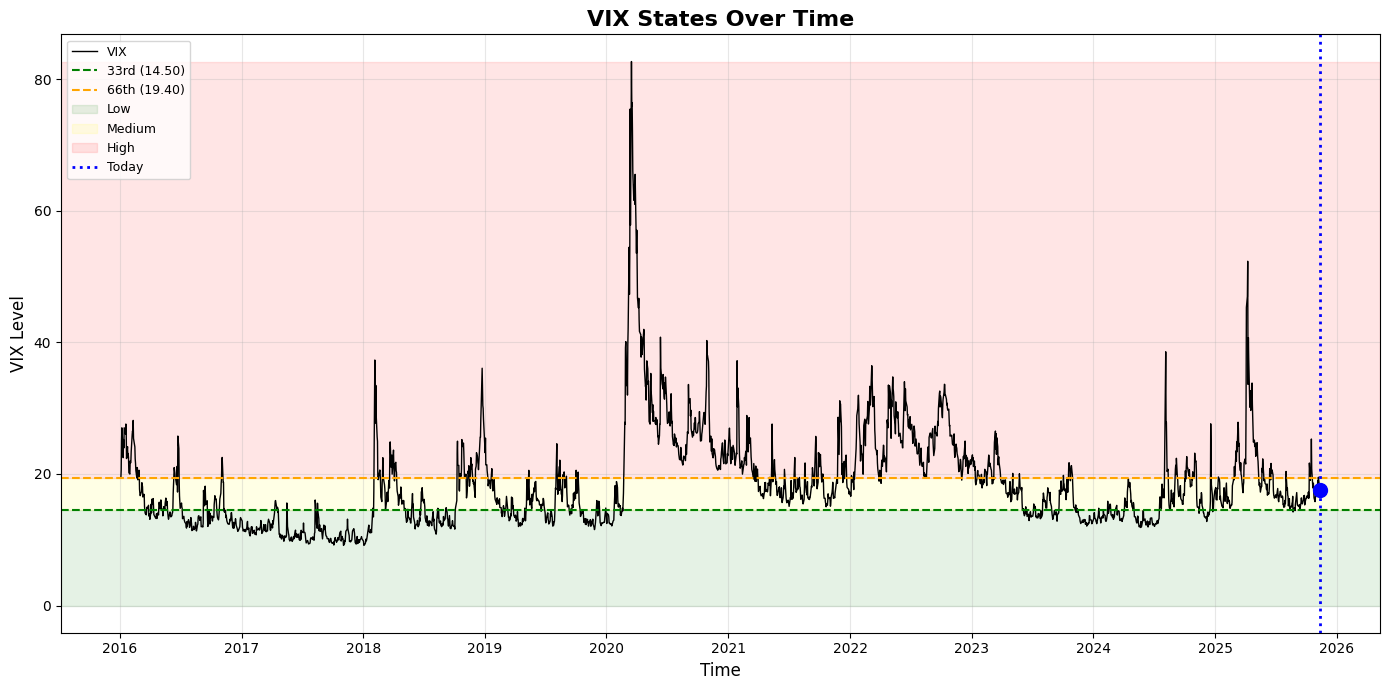

Current: MEDIUM (VIX=17.60)

VIX STATE DURATION STATISTICS
        Avg Days  Median Days  Min Days  Max Days  Total Runs
state                                                        
High        10.0          2.0         1       265          84
Low         13.4          4.0         1       111          61
Medium       5.6          3.0         1        31         146

SUMMARY
Low     : Avg =  13.4 days  |  Median =   4.0 days  |  Runs = 61
Medium  : Avg =   5.6 days  |  Median =   3.0 days  |  Runs = 146
High    : Avg =  10.0 days  |  Median =   2.0 days  |  Runs = 84

Current MEDIUM state has lasted: 3 days


In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create figure
plt.figure(figsize=(14, 7))

# VIX line
plt.plot(vix_aligned.index, vix_aligned.values, color='black', linewidth=1, label='VIX')

# Boundaries
plt.axhline(y=vix_33, color='green', linestyle='--', linewidth=1.5, label=f'33rd ({vix_33:.2f})')
plt.axhline(y=vix_66, color='orange', linestyle='--', linewidth=1.5, label=f'66th ({vix_66:.2f})')

# Regions
plt.axhspan(0, vix_33, alpha=0.1, color='green', label='Low')
plt.axhspan(vix_33, vix_66, alpha=0.1, color='yellow', label='Medium')
plt.axhspan(vix_66, vix_aligned.max(), alpha=0.1, color='red', label='High')

# Current
plt.axvline(x=vix_aligned.index[-1], color='blue', linestyle=':', linewidth=2, label='Today')
plt.scatter(vix_aligned.index[-1], current_vix, color='blue', s=100, zorder=5)

plt.title('VIX States Over Time', fontsize=16, fontweight='bold')
plt.ylabel('VIX Level', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(fontsize=9, loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Current: {state_name} (VIX={current_vix:.2f})")

# ========== CALCULATE STATE DURATIONS ==========

# Classify each observation into states
vix_states = pd.Series(index=vix_aligned.index, dtype='object')
vix_states[vix_aligned <= vix_33] = 'Low'
vix_states[(vix_aligned > vix_33) & (vix_aligned <= vix_66)] = 'Medium'
vix_states[vix_aligned > vix_66] = 'High'

# Identify state changes (when state differs from previous row)
state_changes = (vix_states != vix_states.shift(1))

# Assign a unique ID to each consecutive state period
state_run_id = state_changes.cumsum()

# Group by state run and calculate duration of each run
runs = pd.DataFrame({
    'state': vix_states,
    'run_id': state_run_id
})

# Calculate duration (number of consecutive days) for each run
run_durations = runs.groupby('run_id').agg(
    state=('state', 'first'),
    duration=('state', 'size')
)

# Calculate average duration by state
avg_durations = run_durations.groupby('state')['duration'].agg(['mean', 'median', 'min', 'max', 'count'])
avg_durations.columns = ['Avg Days', 'Median Days', 'Min Days', 'Max Days', 'Total Runs']

print(f"\n{'='*70}")
print("VIX STATE DURATION STATISTICS")
print(f"{'='*70}")
print(avg_durations.round(1))

# Additional summary
print(f"\n{'='*70}")
print("SUMMARY")
print(f"{'='*70}")
for state in ['Low', 'Medium', 'High']:
    if state in avg_durations.index:
        avg = avg_durations.loc[state, 'Avg Days']
        med = avg_durations.loc[state, 'Median Days']
        n_runs = int(avg_durations.loc[state, 'Total Runs'])
        print(f"{state:8s}: Avg = {avg:5.1f} days  |  Median = {med:5.1f} days  |  Runs = {n_runs}")

# Show current run duration
current_run_duration = runs[runs['run_id'] == state_run_id.iloc[-1]].shape[0]
print(f"\nCurrent {state_name} state has lasted: {current_run_duration} days")

In [23]:
# Initial constraints (full universe)
I_full = len(pnl.columns)
v_full = np.ones(I_full)

upper_bound = 0.25
lower_bound = 0

G_full = np.vstack((np.eye(I_full), -np.eye(I_full)))
h_full = np.hstack((upper_bound * np.ones(I_full), -lower_bound * np.ones(I_full)))

R_full = pnl.values

print(f"Full universe: {I_full} instruments")

Full universe: 576 instruments


In [24]:
# Pre-selection: Identify top K assets
print("\n=== PRE-SELECTION ===")

cvar_opt_initial = ft.MeanCVaR(R_full, G_full, h_full, v=v_full, alpha=0.95)
frontier_initial = cvar_opt_initial.efficient_frontier(15)

# Average absolute allocation across frontier
avg_abs_weights = np.mean(np.abs(frontier_initial), axis=1)

# Select top K assets
K = 20 if I_full > 20 else I_full  # Adjust for small universes
top_assets = np.argsort(avg_abs_weights)[-K:]

# Subset data
R = R_full[:, top_assets]
asset_names = [pnl.columns[i] for i in top_assets]
means = means[top_assets]
covariance_matrix = covariance_matrix[np.ix_(top_assets, top_assets)]

# Update prior_stats for later use
prior_stats = prior_stats.iloc[top_assets]

print(f"Selected {K} assets from {I_full}")
print(f"Top assets: {asset_names[:20]}... (showing all)")


=== PRE-SELECTION ===
Selected 20 assets from 576
Top assets: ['NRG', 'TKO', 'COR', 'AVGO', 'CBOE', 'EUR=X', 'TPL', 'AUD=X', 'AMD', 'WMT', 'GBP=X', 'PWR', 'EMC', 'GRN', 'PGR', 'AXON', 'JPY=X', 'LLY', 'NVDA', 'GC=F']... (showing all)


In [25]:
# Constraints on selected universe
I = K
v = np.ones(I)

G = np.vstack((np.eye(I), -np.eye(I)))
h = np.hstack((upper_bound * np.ones(I), -lower_bound * np.ones(I)))

alphas = [0.9, 0.95, 0.975]
cvar_opt = ft.MeanCVaR(R, G, h, v=v, alpha=alphas[0])

short_allowed = "YES" if lower_bound < 0 else "NO"
print(f"\nFinal universe: {I} instruments, {R.shape[0]} scenarios")
print(f"CVaR alphas: {alphas}")
print(f"Limits: {lower_bound*100:.0f}% to {upper_bound*100:.0f}% (Short: {short_allowed})")


Final universe: 20 instruments, 2468 scenarios
CVaR alphas: [0.9, 0.95, 0.975]
Limits: 0% to 25% (Short: NO)


In [26]:
# Bootstrap parameters
B = 99
P = 9
pf_index = 4
N = 100
np.random.seed(3)

print(f"\n{B} scenarios × {N} observations")


99 scenarios × 100 observations


In [27]:
S = R.shape[0]

# Stage 1: VIX state conditioning
A_state = vix_state[np.newaxis, :]
b_state = np.array([[current_state]])
q_state = ft.entropy_pooling(p_exp, A=A_state, b=b_state)

print(f"VIX conditioning: {state_name} (state {current_state})")

# Regime-conditional bootstrap
R_regime = R[vix_state == current_state]
means_regime = R_regime.mean(axis=0)
cov_regime = np.cov(R_regime, rowvar=False)

print(f"Regime data: {len(R_regime)} scenarios from {state_name} state")

# Bootstrap from current regime
return_sim = np.random.multivariate_normal(means_regime, cov_regime, (N, B))

# Storage
frontier_mean90 = np.full((len(v), P, B), np.nan)
frontier_mean95 = np.full((len(v), P, B), np.nan)
frontier_mean975 = np.full((len(v), P, B), np.nan)
results_dict = {alphas[0]: frontier_mean90, alphas[1]: frontier_mean95, alphas[2]: frontier_mean975}

# Bootstrap loop
for b in range(B):
    means_uncertainty = np.mean(return_sim[:, b, :], axis=0)
    
    # Stage 2: Return view conditioning
    q = ft.entropy_pooling(q_state, A=R.T, b=means_uncertainty[:, np.newaxis])
    means_run = q.T @ R
    
    # Frontiers for each alpha
    for alpha in results_dict.keys():
        cvar_opt_run = ft.MeanCVaR(R, G, h, v=v, alpha=alpha, p=q)
        cvar_opt_run._expected_return_row = -matrix(np.hstack((means_run, np.zeros((1, 2)))))
        results_dict[alpha][:, :, b] = cvar_opt_run.efficient_frontier(P)

print(f"{B} frontiers × {len(alphas)} alphas")

# Partition
results = np.full((len(v), P, 3 * B), np.nan)
i = 0
for b in range(B):
    for alpha in results_dict.keys():
        results[:, :, i] = results_dict[alpha][:, :, b]
        i += 1

print(f"Results: {results.shape}")
print("Prior: Time Decay → VIX State → Regime Bootstrap → Return Views")

VIX conditioning: MEDIUM (state 1)
Regime data: 816 scenarios from MEDIUM state
99 frontiers × 3 alphas
Results: (20, 9, 297)
Prior: Time Decay → VIX State → Regime Bootstrap → Return Views


In [28]:
# Stacking
L = 15
print(f"\n=== STACKING (L={L} folds) ===")
es_90 = ft.exposure_stacking(L, frontier_mean90[:, pf_index, :])
es_95 = ft.exposure_stacking(L, frontier_mean95[:, pf_index, :])
es_975 = ft.exposure_stacking(L, frontier_mean975[:, pf_index, :])
es_all = ft.exposure_stacking(L, results[:, pf_index, :])
# Floor enforcement function
def enforce_floor(weights, floor=0.00):
    """Remove positions with |weight| < floor."""
    weights_clean = weights.copy()
    weights_clean[np.abs(weights_clean) < floor] = 0

    total = np.sum(weights_clean)
    if np.abs(total) > 1e-6:
        weights_clean = weights_clean / total

    return weights_clean
# Apply floor
floor_threshold = 0.00
es_90 = enforce_floor(es_90, floor=floor_threshold)
es_95 = enforce_floor(es_95, floor=floor_threshold)
es_975 = enforce_floor(es_975, floor=floor_threshold)
es_all = enforce_floor(es_all, floor=floor_threshold)
# Report positions
print(f"\nFloor: {floor_threshold*100:.0f}% (absolute)")
for name, w in [('90%', es_90), ('95%', es_95), ('97.5%', es_975), ('Combined', es_all)]:
    n_long = np.sum(w > floor_threshold)
    n_short = np.sum(w < -floor_threshold)
    print(f"  {name}: {n_long} long, {n_short} short = {n_long+n_short} total")
# Allocations table
exposures = np.round(np.vstack((es_90, es_95, es_975, es_all)) * 100, 2).T
exposures_df = pd.DataFrame(exposures, index=prior_stats.index, 
                            columns=['90%', '95%', '97.5%', 'Combined'])
# Statistics
portfolios = {'90%': es_90, '95%': es_95, '97.5%': es_975, 'Combined': es_all}
stats_rows = {}
# Trasnforming log rets to simple returns
for name, w in portfolios.items():
    pf_ret_log = R @ w

    # Convert to simple returns for statistics
    pf_ret_simple = np.exp(pf_ret_log) - 1

    mean_ret = np.mean(pf_ret_simple)
    vol_ret = np.std(pf_ret_simple)
    sorted_ret = np.sort(pf_ret_simple)

    stats_rows[name] = {
        'Mean': mean_ret * 100,
        'Volatility': vol_ret * 100,
        'Sharpe': mean_ret / vol_ret if vol_ret > 0 else 0,
        'CVaR 90%': np.mean(sorted_ret[:int(0.1*len(sorted_ret))]) * 100,
        'CVaR 95%': np.mean(sorted_ret[:int(0.05*len(sorted_ret))]) * 100,
        'CVaR 97.5%': np.mean(sorted_ret[:int(0.025*len(sorted_ret))]) * 100
    }
stats_df = pd.DataFrame(stats_rows).T
for stat in stats_df.columns:
    exposures_df.loc[stat] = stats_df[stat].values
print(f"\n{'='*70}")
print("PORTFOLIO ALLOCATIONS")
print(f"{'='*70}")
exposures_df.round(4)


=== STACKING (L=15 folds) ===

Floor: 0% (absolute)
  90%: 20 long, 0 short = 20 total
  95%: 20 long, 0 short = 20 total
  97.5%: 20 long, 0 short = 20 total
  Combined: 20 long, 0 short = 20 total

PORTFOLIO ALLOCATIONS


,90%,95%,97.5%,Combined
NRG,2.4000,2.6700,3.0300,2.9300
TKO,2.6800,2.6900,2.6600,2.1800
COR,2.6600,2.6000,2.6500,3.1300
AVGO,2.0300,1.8200,1.6700,2.2200
CBOE,5.3500,5.3100,5.1400,4.9800
EUR=X,7.9800,8.6300,8.3600,8.3100
TPL,1.8500,1.8900,1.7100,1.5600
AUD=X,4.5200,4.9300,5.0800,4.7700
AMD,2.2600,2.2500,2.2000,1.9700
WMT,6.3200,6.1500,6.1500,6.4400


Regime scenarios (selected 20 assets):
  Low: 815, Medium: 816, High: 837

Low Vol:
  Mean: $1.0814
  5th: $1.0240, 95th: $1.1385

Medium Vol:
  Mean: $1.0880
  5th: $1.0128, 95th: $1.1709

High Vol:
  Mean: $1.0026
  5th: $0.8907, 95th: $1.1212


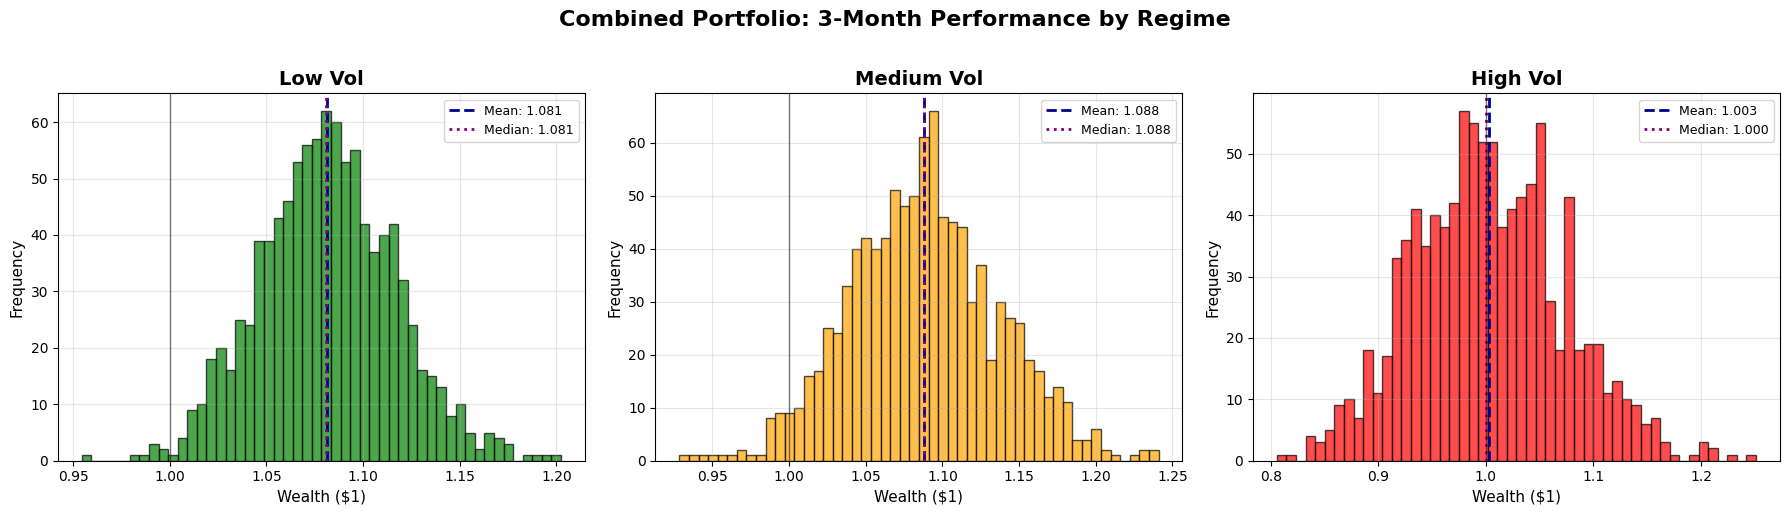

In [29]:
import matplotlib.pyplot as plt

# Combined portfolio
pf_weights = es_all

# Simulation
n_simulations = 1000
n_days = 63
np.random.seed(42)

# Regime-specific data (AFTER pre-selection)
R_low = R[vix_state == 0]
R_med = R[vix_state == 1]
R_high = R[vix_state == 2]

print(f"Regime scenarios (selected {I} assets):")
print(f"  Low: {len(R_low)}, Medium: {len(R_med)}, High: {len(R_high)}")

# Regime statistics
means_low = R_low.mean(axis=0)
cov_low = np.cov(R_low, rowvar=False)

means_med = R_med.mean(axis=0)
cov_med = np.cov(R_med, rowvar=False)

means_high = R_high.mean(axis=0)
cov_high = np.cov(R_high, rowvar=False)

# Simulate
regimes = {
    'Low Vol': (means_low, cov_low, 'green'),
    'Medium Vol': (means_med, cov_med, 'orange'),
    'High Vol': (means_high, cov_high, 'red')
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, (mu, cov, color)) in enumerate(regimes.items()):
    future_log = np.random.multivariate_normal(mu, cov, (n_days, n_simulations))
    future_simple = np.exp(future_log) - 1
    
    final_values = []
    for sim in range(n_simulations):
        daily_ret = future_simple[:, sim, :] @ pf_weights
        final_values.append((1 + daily_ret).prod())
    
    final_values = np.array(final_values)
    
    # Plot
    axes[idx].hist(final_values, bins=50, alpha=0.7, color=color, edgecolor='black')
    axes[idx].axvline(np.mean(final_values), color='darkblue', linestyle='--', 
                     linewidth=2, label=f'Mean: {np.mean(final_values):.3f}')
    axes[idx].axvline(np.median(final_values), color='purple', linestyle=':', 
                     linewidth=2, label=f'Median: {np.median(final_values):.3f}')
    axes[idx].axvline(1.0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    axes[idx].set_title(f'{name}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Wealth ($1)', fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].legend(fontsize=9)
    axes[idx].grid(alpha=0.3)
    
    print(f"\n{name}:")
    print(f"  Mean: ${np.mean(final_values):.4f}")
    print(f"  5th: ${np.percentile(final_values, 5):.4f}, 95th: ${np.percentile(final_values, 95):.4f}")

plt.suptitle('Combined Portfolio: 3-Month Performance by Regime', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()